Firstly, import the fortran disk model routines and the python likelihood functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from diskmodels import profileell,profilecirc,profileell2d,profilecirc2d
from diskfit import likelihood, utils
from scipy.optimize import minimize

Load the continuum subtracted spectrum. Establish the redshift and narrow line width in Angstroms. 

In [2]:
fn = '../data/ZTF18aahiqst_subtracted.txt'
wl,flux,fluxerr = utils.readspec(fn)
z = 0.0745
narrowmu = 3.9

Extract the region of the spectrum containing the double-peaked profile, and store the size of the spectrum in npix

In [3]:
olambda = 6564.614#6563 # nominal wavelength of the Halpha line (Angstrom)
wavemin = 6300  # minimum wavelength (Angstrom)
wavemax = 6900  # maximum wavelength (Angstrom)
wave = wl/(1+z) # Convert the spectrum to rest frame wavelength
indwave = np.argwhere((wave>wavemin)&(wave<wavemax))[:,0]
wave = np.asarray(wave[indwave],dtype=np.float64)
flux = flux[indwave]
fluxerr = fluxerr[indwave]
npix = wave.shape[0]

Set all the parameters which will remain fixed to pre-determined values during the fitting

In [4]:
# Integration, units, normalization

maxstep = 400
maxwave = 10000
nstep = 100 # integration steps (integer, </= 400)
relativistic = 'y' #  include relativistic effects? (y/n) [y]
normalization = 'max' # profile normalization scheme (max/flux/none) [max]fluxunits = 'flam' # flux density units (fnu/flam) [fnu]

# Circular disk size and emission properties

q1 = 1.7 #inner emissivity powerlaw index
q2 = 1.9 #outer emissivity powerlaw index
xib = 0.6 #power-law index break radius (XIB=0 causes Q=Q2 throughout)

# Wind properties
t0 = 1e-7   # optical depth normalization (0=no wind)
eta = 0. #optical depth power-law index
anglam = 15 #wind opening angle (degrees)
version = 'f' #formula for escape probability (f=Flohic, m=Murray)

# Spiral arms
amp = 0. #contrast of spiral arm (0=no arms)
narms = 1 #number of arms (integer)
aobs = 95 #spiral orientation (degrees, +ve=outer, -ve=inner)
pitch = -20 #pitch angle of spiral pattern (+ve=leading, -ve=trailing)
width = 40 #angular width of arm (degrees)
xispin = 0 #inner spiral arm radius radius (GM/c^2, 0=XI1)
xispout = 0 #outer spiral arm radius radius (GM/c^2, 0=XI2)


Create a dictionary of the fixed parameter names and values

In [5]:
fixed_labels = ['q1','q2','xib','maxstep','anglam','t0','eta','version','amp','narms','aobs','pitch','width','xispin','xispout','nstep','relativistic','olambda','npix']
fixed_values = [q1,q2,xib,maxstep,anglam,t0,eta,version,amp,narms,aobs,pitch,width,xispin,xispout,nstep,relativistic,olambda,npix]
fixed = dict(zip(fixed_labels,fixed_values))

Set initial guesses for the parameters to be fitted

In [6]:
angi = 25 #disk inclination angle (degrees)
xi1 = 134 #inner disk radius (GM/c^2)
xi2 = 34 #outer disk radius (multiple of xi1)
broad = 600 #broadening parameter (km/s)

Create a dictionary of fitted parameter names and values

In [7]:
fitted_labels = ['xi1','xi2','broad','angi']
initial = [xi1,xi2,broad,angi]
fitted = dict(zip(fitted_labels,initial))

Set wavelengths of narrow emission lines to be included in the fit and create the array of line profiles

In [8]:
NIIa = 6549.86
Halpha = 6564.614
NIIb = 6585.27
SIIa = 6718.29
SIIb = 6732.68
lines = [Halpha,NIIa,NIIb,SIIa,SIIb]

Plot initial model against spectrum

In [9]:
modelguess = likelihood.model_linefit_circ(initial, wave, flux, fluxerr, lines, narrowmu, fixed, fitted)

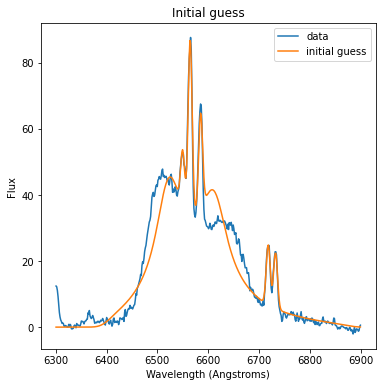

<Figure size 432x288 with 0 Axes>

In [10]:
plt.figure(figsize=(6,6))
plt.plot(wave,flux,label='data')
plt.plot(wave,modelguess,label='initial guess')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.title('Initial guess')
plt.legend()
plt.show()
plt.clf()

Establish bounds for fitted parameters. These will be used to make a uniform prior.

In [11]:
angimax = 89.9
angimin= 0.1
xi1min = 100
xi1max = 2000
xi2min = 1.01
xi2max = 40
broadmin = 0
broadmax = 1000
diskmins = [xi1min,xi2min,broadmin,angimin]
diskmax = [xi1max,xi2max,broadmax,angimax]

In [12]:
lp = likelihood.logprob_circ(wave, flux, fluxerr, lines, narrowmu, fixed, fitted, diskmins, diskmax)

Use scipy.optimize.minimize to find a simple solution for the fitted parameters

In [13]:
nll = lambda *args: -lp(*args)
soln = minimize(nll, initial, method='Nelder-Mead')
modelfit = lp.test(soln.x)
print('Best-fit parameter values', soln.x)

Best-fit parameter values [232.58182144   8.83435965 684.60963193  22.49372653]


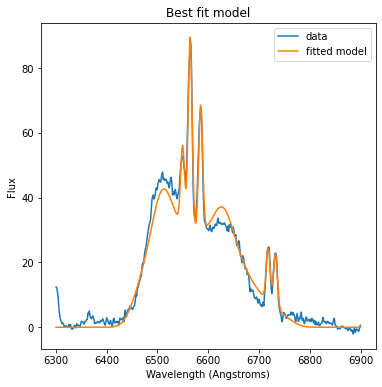

<Figure size 432x288 with 0 Axes>

In [14]:
plt.figure(figsize=(6,6))
plt.plot(wave,flux,label='data')
plt.plot(wave,modelfit,label='fitted model')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.title('Best fit model')
plt.legend()
plt.show()
plt.clf()

Now import the emcee module to sample the parameter space, with walkers initialized around the best fit parameters from the previous step. Run the sampler for 1000 iterations and save the progress to file. 

In [15]:
import emcee
pos = soln.x + 5e-2 * soln.x * np.random.randn(20, soln.x.shape[0])
nwalkers, ndim = pos.shape
filename ='emcee.h5'
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
        nwalkers, ndim, lp, args=(), backend=backend
    )
sampler.run_mcmc(pos, 1000, progress=True)

100%|█████████████████████████████████| 1000/1000 [52:32<00:00,  3.15s/it]


State([[194.96181375  10.01423069 686.13718831  21.73824573]
 [193.36242353  10.13034876 662.01734658  21.68838404]
 [188.31539596  10.38790706 665.73112067  21.47472646]
 [194.65630054  10.11198672 699.80430547  21.58952099]
 [189.61763867  10.00446025 695.80987014  21.36215608]
 [193.22229649   9.971391   695.54160238  21.43717734]
 [193.12208779   9.92812121 688.42924851  21.42013072]
 [187.1175216   10.42054161 692.9752159   21.49729158]
 [182.17475629  10.6019277  691.86417594  21.45701758]
 [206.43055087   9.62346608 699.33839783  21.82941772]
 [188.80243561  10.36651867 698.57309785  21.59230546]
 [179.37199817  10.6668769  712.12271658  21.19124844]
 [185.21863917  10.17200002 687.40441263  21.16136729]
 [195.6748959    9.56918099 728.2551843   21.33948892]
 [193.58144973   9.9295438  679.40195882  21.40592661]
 [183.46697129  10.24659071 664.39784411  21.36001589]
 [176.27430953  10.5990712  678.37583179  21.00016453]
 [181.3649581   10.55946171 702.415002    21.25218638]
 [18

Print the parameters and uncertainties found by the sampler

In [16]:
from IPython.display import display, Math
flat_samples = sampler.get_chain(discard=200, flat=True)
for i,l in enumerate(fitted_labels):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], fitted_labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Make a corner plot of the parameter samples

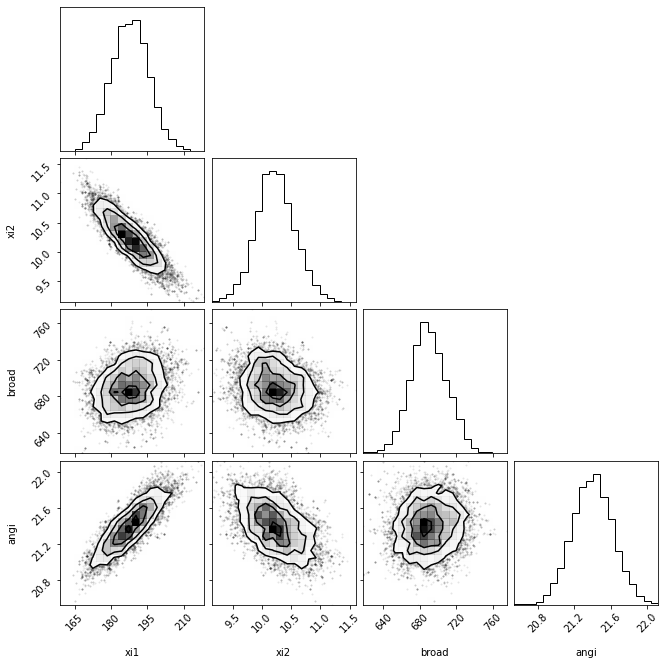

In [17]:
import corner
fig = corner.corner(
            flat_samples, labels=fitted_labels)
plt.show()

Plot the sampler chains 

<Figure size 432x432 with 0 Axes>

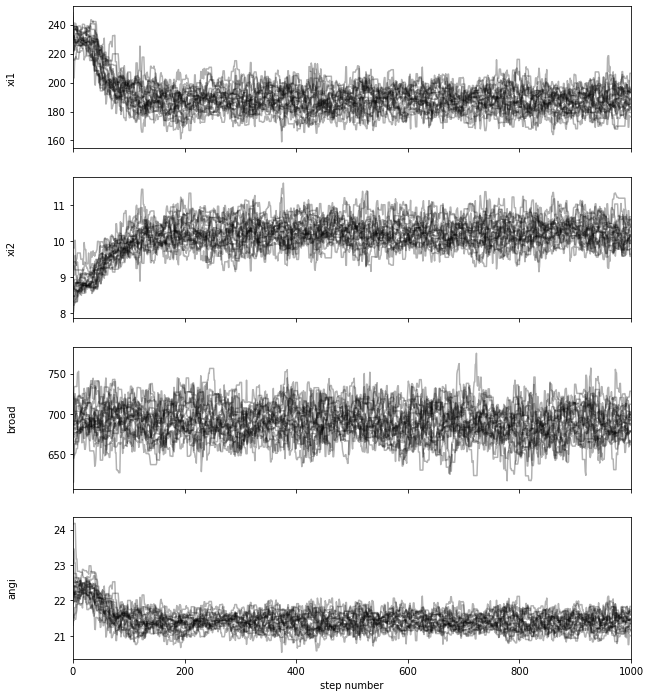

<Figure size 432x288 with 0 Axes>

In [18]:
plt.figure(figsize=(6,6))
fig, axes = plt.subplots(soln.x.shape[0], figsize=(10,3*soln.x.shape[0]), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(fitted_labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");
plt.show()
plt.clf()

Plot the range of good fits found by the sampler

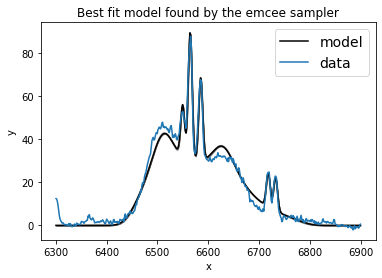

<Figure size 432x288 with 0 Axes>

In [19]:
from ultranest.plot import PredictionBand
band = PredictionBand(wave)
inds = np.random.randint(len(flat_samples), size=10)
for ind in inds:
    sample = flat_samples[ind]
    modelfit = lp.test(sample)
    band.add(modelfit)
    plt.plot(wave,modelfit,alpha=0.1)

band.line(color='k',label='model')
# add 1 sigma quantile
band.shade(color='k', alpha=0.5)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='gray', alpha=0.2);

plt.plot(wave,flux,label='data')
plt.title('Best fit model found by the emcee sampler')
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");
plt.show()
plt.clf()